In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

In [2]:
def read_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    #Drop the ID column since it is unnecessary for the prediction process
    train.drop("Id",axis =1,inplace = True)
    test.drop("Id",axis =1,inplace= True)
    print('reading data done...')
    return train,test

In [3]:
def remove_outlier(train):
    train["SalePrice"] = np.log1p(train["SalePrice"])
    #Deleting Outliers of GrLivArea
    train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
    train=train.reset_index()
    print('removing oulier done...')
    return train


In [4]:
def concate_data(train,test):
    all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True)
    print("all_data size is: {} ".format(all_data.shape))
    print('Concating data done ...')
    return all_data
def missing_count(all_data):
    all_data_na = (all_data.isnull().sum()/ len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
    all_data_na=all_data_na.sort_values(ascending = False)
    missing_data =pd.DataFrame({'Missing Raio':all_data_na[all_data_na>0.0]})
    miss_cols=list(missing_data.index)
    num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
    i=0
    m_cat_feat=[]
    m_con_feat=[]
    m_dis_feat=[]
    m_all=[]
    for col in miss_cols:
        if col in cat_feat:
            m_cat_feat.append(col)
            m_all.append('catagorical')
        if col in con_feat:
            m_con_feat.append(col)
            m_all.append('continuous')
        if col in dis_feat:
            m_dis_feat.append(col)
            m_all.append('discrete')
        i=i+1
    missing_data['type']=m_all
    #for col in m_cat_feat:
    #    all_data[col]=all_data.fillna('Missing',inplace=True)
    #for col in m_con_feat:
    #    all_data[col]=all_data.fillna(all_data[col].mode()[0],inplace=True)
    
    return missing_data,m_cat_feat,m_con_feat,m_dis_feat

In [5]:
def handle_missing_values(data):
    # below categorical basement-related feature NaN means that there is no basement 
    none_cols=['PoolQC','MiscFeature','GarageType','Alley','Fence','FireplaceQu','GarageFinish',
               'GarageQual','GarageCond','MasVnrType','MSSubClass','BsmtQual', 'BsmtCond','BsmtExposure',
               'BsmtFinType1','BsmtFinType2']
    for col in none_cols:
        data[col] = data[col].fillna('None')
    #Replacing missing value with 0(since no garage = no cars in such garage)
    #missing values are likely zero for no basement 
    zero_cols=['GarageYrBlt','GarageArea', 'GarageCars','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
    for col in zero_cols:
        data[col] = data[col].fillna(0)

    # NA is typical
    data["Functional"] = data["Functional"].fillna('Typ')

    #dropping as same value 
    #data = data.drop(['Utilities'], axis=1)
    mode_cols=['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    #group by Neigborhood and fill missing value with median Lot frontage of all the neighboorhood
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    #add total surface area as TotalSf = basement + firstflr + secondflr
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    print('Missing alues handling done ...')
    return data

In [6]:
def test_corr():
    df=train[['MSSubClass','Neighborhood','SalePrice']].copy()
    df['MSSubClass']=df['MSSubClass'].astype(str)
    df["MSSubClass"] = df.MSSubClass.map({'180':1, 
                                            '30':2, '45':2, 
                                            '190':3, '50':3, '90':3, 
                                            '85':4, '40':4, '160':4, 
                                            '70':5, '20':5, '75':5, '80':5, '150':5,
                                            '120': 6, '60':6})
    #lbl=LabelEncoder()
    #df['Neighborhood']=lbl.fit(df.Neighborhood).transform(df.Neighborhood)
    df["Neighborhood"] = df.Neighborhood.map({'MeadowV':1,
                                                   'IDOTRR':2, 'BrDale':2,
                                                   'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                                   'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                                   'NPkVill':5, 'Mitchel':5,
                                                   'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                                   'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                                   'Veenker':8, 'Somerst':8, 'Timber':8,
                                                   'StoneBr':9,
                                                   'NoRidge':10, 'NridgHt':10})

    corr=df.corr()
    print('corr',corr)
    #-0.075083, 0.54827
    #0.20153, 0.74731
    return 0

In [7]:
def get_corr_list(all_data,_feat,thr,enc):
    #correration matrix
    #ob.append('SalePrice')
    all_obj_data=all_data.loc[:len(train),_feat]
    all_obj_data['SalePrice']=train['SalePrice']
    target='SalePrice'
    if enc=='ord_enc':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[target].mean()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    if enc=='lbl_enc':
        for col in _feat:
                lbl = LabelEncoder()
                lbl.fit(list(all_obj_data[col].values))
                all_obj_data[col] = lbl.transform(list(all_obj_data[col].values))

    corrmat = all_obj_data.corr()
    corrmat['SalePrice']=corrmat['SalePrice'].abs()
    corrmat1=corrmat.sort_values( by=['SalePrice'],ascending=False)
    cm=(corrmat1['SalePrice'].abs())
    corr_cols=list(cm[cm>thr].index)
    corr_cols=corr_cols[1:]
    #print(cm)
    #print(len(corr_cols))
    #all_data.drop(corr_cols,axis=1,inplace=True)
    return cm,corr_cols
    #9.50759234513011
    #9.563138228351098

In [8]:
def ordinal_encode(_data,cols):
    target='SalePrice'
    data=_data.loc[:len(train),:].copy()
    data[target]=train.SalePrice
    for feat in cols:
        ordered_labels = data.groupby([feat])[target].mean()
        ordered_labels=ordered_labels.sort_values().index
        ordinal_label = {}
        for i, k in enumerate(ordered_labels, 0):
            ordinal_label[k]=i
        print(ordinal_label)
        _data.loc[:,feat]=_data.loc[:,feat].map(ordinal_label)
    return _data

In [9]:
def label_encode(data,cols):
    
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(all_data[c].values))
        data[c] = lbl.transform(list(all_data[c].values))
    #shape
    print('Shape all_data: {}'.format(all_data.shape))
    print('label encoding done ...')
    return data

In [10]:
def get_feat_count(all_data):
    num_feat = all_data.dtypes[all_data.dtypes != "object"].index
    con_feat=[]
    dis_feat=[]
    for feat in num_feat:
        uniq=all_data[feat].unique()
        if len(uniq)>20:
            con_feat.append(feat)
        if len(uniq)<=20:
            dis_feat.append(feat)
    cat_feat = all_data.dtypes[all_data.dtypes == "object"].index
    print('catagorical feat',len(cat_feat))
    print('numeric feat',len(num_feat))
    print('continuous feat',len(con_feat))
    print('discrete feat',len(dis_feat))
    return num_feat,cat_feat,con_feat,dis_feat

In [11]:
'''
PoolQC           99.725557  catagorical
MiscFeature      96.397942  catagorical
Alley            93.207547  catagorical
Fence            80.445969  catagorical
FireplaceQu      48.713551  catagorical
LotFrontage      16.672384   continuous
GarageFinish      5.454545  catagorical
GarageYrBlt       5.454545   continuous
GarageQual        5.454545  catagorical
GarageCond        5.454545  catagorical
GarageType        5.385935  catagorical
BsmtExposure      2.813036  catagorical
BsmtCond          2.813036  catagorical
BsmtQual          2.778731  catagorical
BsmtFinType2      2.744425  catagorical
BsmtFinType1      2.710120  catagorical
MasVnrType        0.823328  catagorical
MasVnrArea        0.789022   continuous
MSZoning          0.137221  catagorical
'''
'''
smtFullBath      0.068611     discrete
BsmtHalfBath      0.068611     discrete
Utilities         0.068611  catagorical
Functional        0.068611  catagorical
Exterior2nd       0.034305  catagorical
Exterior1st       0.034305  catagorical
SaleType          0.034305  catagorical
BsmtFinSF1        0.034305   continuous
BsmtFinSF2        0.034305   continuous
BsmtUnfSF         0.034305   continuous
Electrical        0.034305  catagorical
KitchenQual       0.034305  catagorical
GarageCars        0.034305     discrete
GarageArea        0.034305   continuous
TotalBsmtSF       0.034305   continuous
'''
def handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols):
    mode_cols=['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
    
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    #group by Neigborhood and fill missing value with median Lot frontage of all the neighboorhood
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    data['GarageYrBlt_NA'] =np.array(data['GarageYrBlt']>0)

    #add total surface area as TotalSf = basement + firstflr + secondflr
    zero_cols=['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    
    for col in m_cat_cols:
        data[col] = data[col].fillna('None')
    for col in m_con_cols:
        data[col] = data[col].fillna(0)
    for col in m_dis_cols:
        data[col]=data[col].fillna(0)
    print('Missing values handling done ...')
    return data

In [12]:
def impute_rare(all_data,cols,min_occ):
    data=all_data.copy()
    for feat in cols:
        temp = data.groupby([feat])
        denom=np.float(len(data))#/len(data[feat].unique())
        temp=temp[feat].count()#/(denom)
        frequent_cat = [x for x in temp.loc[temp>=min_occ].index.values]
        data[feat] = np.where(data[feat].isin(frequent_cat), data[feat], 'Rare')
    return data

In [13]:
def get_skewness(all_data,feat):
    skewed_features = all_data[feat].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    print ("Skewness : \n")
    skewness = pd.DataFrame({'Skew' :skewed_features})   
    skewness.head(5)    
    return skewness
def unscew_features(skewness,all_data,thr=.75):
    skewness = skewness[abs(skewness) > 0.75]
    print ("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p 
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        all_data[feat] = boxcox1p(all_data[feat], lam)
    #all_data.drop(['Exterior2nd'],axis=1,inplace=True)
    return all_data

In [14]:

#map_values()
#all_data['SaleCondition'].dtypes
train,test=read_data()
train=remove_outlier(train)
all_data=concate_data(train,test)



num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)

varr_feat=[]
for col in cat_feat:
    lbl_count=len(all_data[col].unique())#.count()
    if lbl_count>=20:
        varr_feat.append(col)
print('varr features',len(varr_feat))
#all_data=ordinal_encode(all_data,varr_feat)

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
miss_data,m_cat_cols,m_con_cols,m_dis_cols=missing_count(all_data)
#print(miss_data)
all_data=handle_missing_values_new(all_data,m_cat_cols,m_con_cols,m_dis_cols)
#all_data=impute_rare(all_data,cat_feat,min_occ=5)
#all_data=ordinal_encode(all_data,cat_feat)
#all_data=handle_missing_values(all_data)
cm,corr_feat=get_corr_list(all_data,cat_feat,thr=0.3,enc='lbl_enc')
#all_data=ordinal_encode(all_data,corr_feat)
all_data=label_encode(all_data,corr_feat)
#len(all_data[num_feat[1]].unique())

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
skewness=get_skewness(all_data,num_feat)
all_data=unscew_features(skewness,all_data,thr=.75)

all_data = pd.get_dummies(all_data)
print(all_data.shape)

all_data.replace(np.nan,0,inplace=True)
all_data.replace(np.inf,0,inplace=True)
all_data=all_data.fillna(0)
    
robust_scaler = RobustScaler()
_all_data = robust_scaler.fit(all_data).transform(all_data)

reading data done...
removing oulier done...
all_data size is: (2915, 79) 
Concating data done ...
catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15
varr features 1
catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15
catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15
Missing values handling done ...
Shape all_data: (2915, 81)
label encoding done ...
catagorical feat 33
numeric feat 48
continuous feat 22
discrete feat 26
Skewness : 

There are 48 skewed numerical features to box cox transform
(2915, 269)


In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
_train = pd.DataFrame(_all_data[:ntrain])
_test = pd.DataFrame(_all_data[ntrain:])

In [16]:
# Create linear regression object
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#regr = linear_model.LinearRegression()
regr=linear_model.Ridge(alpha=8)
regr.fit(_train.values,y_train)
#test.loc[133,cols[160:170]]=test.loc[134,cols[160:170]]
res=regr.predict(np.array(_test.values))


In [17]:
score1=cross_val_score(regr, _train.values, y_train, scoring="neg_mean_squared_error",cv = 10)
score2=cross_val_score(regr, _train.values, y_train, scoring="r2",cv = 10)
print(score1.mean(),score1.std())
print(score2.mean(),score1.std())



-0.012152621840950594 0.00312892304534385
0.9226748612033606 0.00312892304534385


In [18]:
rres_exp=np.exp(res)
print(len(rres_exp))
data='Id,SalePrice\n'
Id=1461
for row in rres_exp:
    data+=str(Id)+','+str(row)+'\n'
    Id+=1
file=open('sub12_Linear Regression_lbl_enc_ridge V-6.0.csv','w')
file.write(data)
file.close()

1459


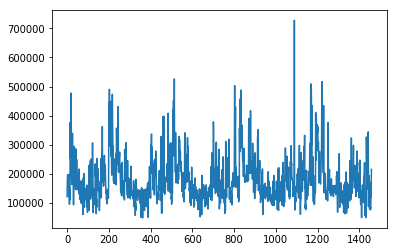

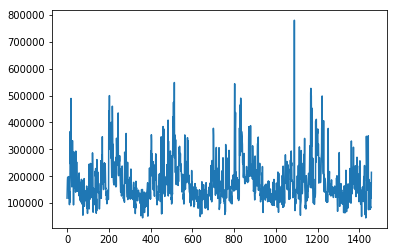

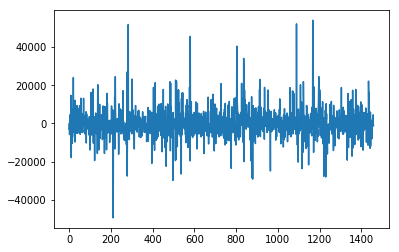

0.0015565308065263524


In [19]:
test_check=pd.read_csv('submission.csv')
c_res=test_check['SalePrice']
plt.plot(c_res)
plt.show()
plt.plot(rres_exp)
plt.show()
plt.plot(rres_exp-c_res)
plt.show()
er=mean_squared_error(np.log(rres_exp),np.log(c_res))
print(er)

In [20]:
'''
SalePrice        1.000000
ExterQual        0.584138
BsmtQual         0.574916
KitchenQual      0.530470
GarageType       0.504519
HeatingQC        0.425864
GarageFinish     0.414554
Foundation       0.412103
CentralAir       0.353707
GarageCond       0.325360
PavedDrive       0.306194
BsmtExposure     0.299405
Electrical       0.295738
GarageQual       0.276776
LotShape         0.273934
SaleCondition    0.260785
HouseStyle       0.211675
Neighborhood     0.201530
MSZoning         0.190488
RoofStyle        0.185602
ExterCond        0.148117
Fence            0.143320
Heating          0.140651
Exterior2nd      0.13322
'''
'''
SalePrice        1.000000
Neighborhood     0.742644
ExterQual        0.680947
KitchenQual      0.667174
BsmtQual         0.647231
GarageFinish     0.604917
GarageType       0.578402
Foundation       0.550950
FireplaceQu      0.547226
HeatingQC        0.474218
MasVnrType       0.435812
Exterior1st      0.415804
MSZoning         0.412798
Exterior2nd      0.402421
BsmtFinType1     0.395803
GarageCond       0.379780
GarageQual       0.360675
CentralAir       0.353707
BsmtExposure     0.353555
'''
cm

SalePrice        1.000000
ExterQual        0.584138
BsmtQual         0.574916
KitchenQual      0.530470
GarageType       0.504519
HeatingQC        0.425864
GarageFinish     0.414554
Foundation       0.412103
CentralAir       0.353707
GarageCond       0.325360
PavedDrive       0.306194
BsmtExposure     0.299405
Electrical       0.295738
GarageQual       0.276776
LotShape         0.273934
SaleCondition    0.260785
HouseStyle       0.211675
Neighborhood     0.201530
MSZoning         0.190488
RoofStyle        0.185602
ExterCond        0.148117
Fence            0.143320
Heating          0.140651
Exterior2nd      0.133223
Functional       0.131315
Exterior1st      0.123907
BsmtFinType1     0.123903
BsmtCond         0.121947
Condition1       0.117003
Alley            0.113820
RoofMatl         0.085923
BsmtFinType2     0.071324
BldgType         0.071098
MiscFeature      0.070772
LotConfig        0.064371
Street           0.057595
FireplaceQu      0.053667
LandSlope        0.040114
PoolQC      

In [21]:
all_col=m_cat_cols+m_con_cols+m_dis_cols
zero_cols=['GarageYrBlt','GarageArea', 'GarageCars','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
mode_cols=['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
for col in zero_cols:
    if col in m_con_cols:
        print(col)

GarageYrBlt
GarageArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
MasVnrArea
